# Installation

In [207]:
%pip install -qU pandas matplotlib seaborn lightfm

Note: you may need to restart the kernel to use updated packages.


# Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
streamers_df = pd.read_csv('Streamers.csv')
user_activity_df = pd.read_csv('Users_Activity.csv')
users_df = pd.read_csv('Users.csv')

### Users activity

In [3]:
user_activity_df['timestamp'] = pd.to_datetime(user_activity_df['timestamp'])
user_activity_df = user_activity_df.sort_values(by=['userId', 'streamerId', 'timestamp'])

def calculate_stream_duration(df):
    open_time = None
    total_duration = pd.Timedelta(0)

    for _, row in df.iterrows():
        if row['event'] == 'user opened stream':
            open_time = row['timestamp']
        elif row['event'] == 'user closed stream' and open_time is not None:
            total_duration += row['timestamp'] - open_time
            open_time = None
    
    return total_duration


result_df = user_activity_df.groupby(['userId', 'streamerId']).apply(calculate_stream_duration).reset_index()

/tmp/ipykernel_1477087/2953409395.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = user_activity_df.groupby(['userId', 'streamerId']).apply(calculate_stream_duration).reset_index()


In [4]:
result_df.columns = ['userId', 'streamerId', 'duration']
result_df = result_df[result_df['duration'] > pd.Timedelta(0)]

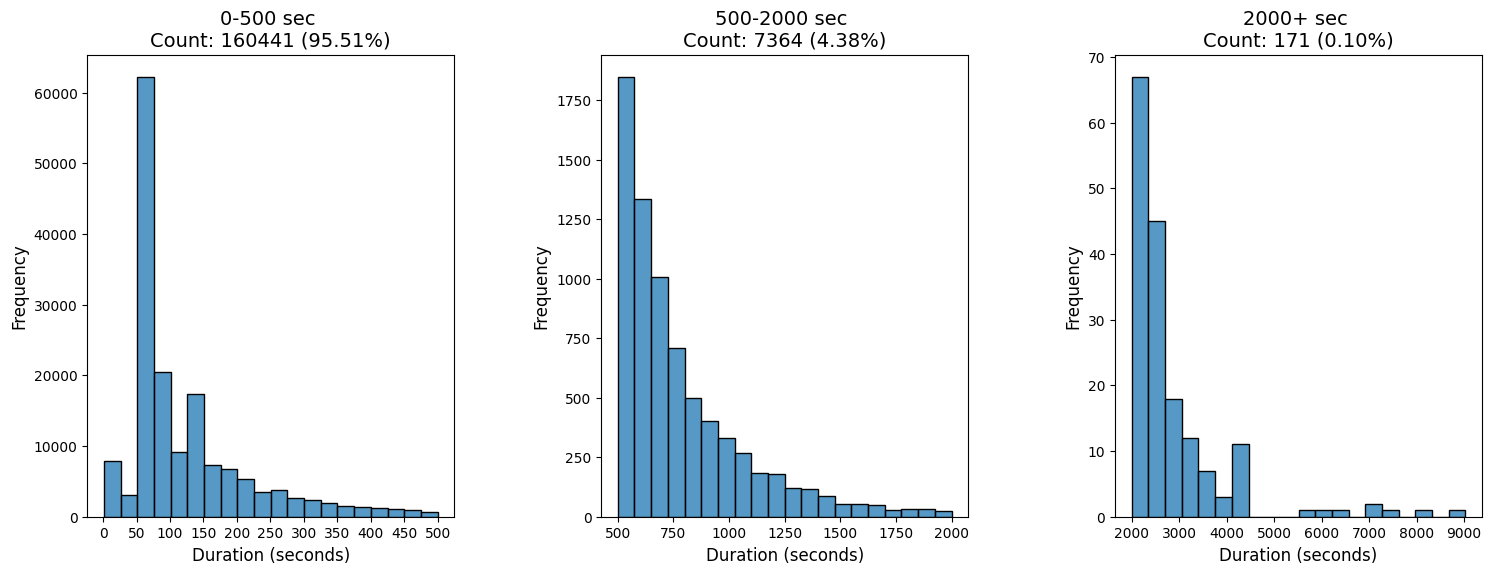

In [5]:
result_df['duration_seconds'] = result_df['duration'].dt.total_seconds()
bins = [0, 500, 2000, result_df['duration_seconds'].max()]
labels = ['0-500 sec', '500-2000 sec', '2000+ sec']
result_df['duration_group'] = pd.cut(result_df['duration_seconds'], bins=bins, labels=labels, include_lowest=True)

group_counts = result_df['duration_group'].value_counts().sort_index()
group_percent = (group_counts / len(result_df)) * 100

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.subplots_adjust(wspace=0.4)
x_ticks_0_500 = np.arange(0, 501, 50)
x_ticks_500_2000 = np.arange(500, 2001, 250)
x_ticks_2000_max = np.arange(2000, result_df['duration_seconds'].max() + 500, 1000)


def plot_histogram(group_name, data, count, percent, ax, x_ticks):
    sns.histplot(data, bins=20, kde=False, ax=ax)
    ax.set_title(f'{group_name} \nCount: {count} ({percent:.2f}%)', fontsize=14)
    ax.set_xlabel('Duration (seconds)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_xticks(x_ticks)


plot_histogram(
    '0-500 sec', 
    result_df[result_df['duration_group'] == '0-500 sec']['duration_seconds'], 
    group_counts['0-500 sec'], 
    group_percent['0-500 sec'], 
    axes[0], 
    x_ticks_0_500
)
plot_histogram(
    '500-2000 sec', 
    result_df[result_df['duration_group'] == '500-2000 sec']['duration_seconds'], 
    group_counts['500-2000 sec'], 
    group_percent['500-2000 sec'], 
    axes[1], 
    x_ticks_500_2000
)
plot_histogram(
    '2000+ sec', 
    result_df[result_df['duration_group'] == '2000+ sec']['duration_seconds'], 
    group_counts['2000+ sec'], 
    group_percent['2000+ sec'], 
    axes[2], 
    x_ticks_2000_max
)

plt.show()

In [6]:
result_df = result_df[['userId', 'streamerId', 'duration_seconds']].reset_index(drop=True)
result_df['duration_seconds'] = result_df['duration_seconds'].astype(int)
result_df

,userId,streamerId,duration_seconds
0,61fc137168755e649c96eaa5,6268acb8bb5d76261cde95be,138
1,61fc137168755e649c96eaa5,62a4d9b4b7c37978d7afd857,62
2,61fc137168755e649c96eaa5,62bb2adffe47f447837d4693,2
3,61fc137168755e649c96eaa5,62bdc96402608123bb91954e,86
4,61fc137168755e649c96eaa5,62bdcf83026081a7fb9196eb,296
...,...,...,...
167971,633b76f694c9c82f2a4aae67,62ea2b9c6302a736a953a5ed,68
167972,633b76f694c9c82f2a4aae67,630d0f90b5f77222e86a4a71,75
167973,633b76f694c9c82f2a4aae67,6338263c94c9c82f2a49af21,68
167974,633b76f694c9c82f2a4aae67,633b66a808aa4f2581ad757b,70


### Users

In [7]:
users_df.loc[users_df['followings'].isna(), "followings"] = 0
users_df['gender_category'] = users_df['gender'].astype('category').cat.codes
users_df['media_source_category'] = users_df['media_source'].astype('category').cat.codes
users_df = users_df[['userId', 'followings', 'gender_category', 'media_source_category']]
users_df

,userId,followings,gender_category,media_source_category
0,633b273f94c9c82f2a4a935e,0.0,1,1
1,6331463d3750b151715b8bca,20.0,1,2
2,6339b3f708aa4f2581acf38e,0.0,1,1
3,63399a5508aa4f2581acecf5,0.0,1,1
4,6337b7b194c9c82f2a499725,0.0,1,1
...,...,...,...,...
10390,633ad82094c9c82f2a4a8005,13.0,0,0
10391,6339320e94c9c82f2a4a0e5d,0.0,1,1
10392,6333a0e83750b1cf2c5c41f2,4.0,1,1
10393,633824a008aa4f2581ac863e,0.0,1,1


In [14]:
users_df['followings_bin'] = pd.cut(users_df['followings'], bins=5, labels=False)
followings_dummies = pd.get_dummies(users_df['followings_bin'], prefix='followings_bin')
gender_dummies = pd.get_dummies(users_df['gender_category'], prefix='gender')
media_source_dummies = pd.get_dummies(users_df['media_source_category'], prefix='media_source')
users_encoded_df = pd.concat([users_df.drop(columns=['followings', 'followings_bin', 'gender_category', 'media_source_category']), followings_dummies, gender_dummies, media_source_dummies], axis=1)
users_encoded_df.iloc[:, 1:] = users_encoded_df.iloc[:, 1:].astype(int)
users_encoded_df

,userId,followings_bin_0,followings_bin_1,followings_bin_2,followings_bin_4,gender_0,gender_1,gender_2,media_source_0,media_source_1,media_source_2,media_source_3,media_source_4,media_source_5
0,633b273f94c9c82f2a4a935e,1,0,0,0,0,1,0,0,1,0,0,0,0
1,6331463d3750b151715b8bca,1,0,0,0,0,1,0,0,0,1,0,0,0
2,6339b3f708aa4f2581acf38e,1,0,0,0,0,1,0,0,1,0,0,0,0
3,63399a5508aa4f2581acecf5,1,0,0,0,0,1,0,0,1,0,0,0,0
4,6337b7b194c9c82f2a499725,1,0,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10390,633ad82094c9c82f2a4a8005,1,0,0,0,1,0,0,1,0,0,0,0,0
10391,6339320e94c9c82f2a4a0e5d,1,0,0,0,0,1,0,0,1,0,0,0,0
10392,6333a0e83750b1cf2c5c41f2,1,0,0,0,0,1,0,0,1,0,0,0,0
10393,633824a008aa4f2581ac863e,1,0,0,0,0,1,0,0,1,0,0,0,0


### Streamers

In [9]:
streamers_df['gender_category'] = streamers_df['gender'].astype('category').cat.codes
streamers_df['streamer_type_category'] = streamers_df['streamer_type'].astype('category').cat.codes

In [10]:
streamers_df.loc[streamers_df['followers'].isna(), 'followers'] = 0
streamers_df.loc[streamers_df['coins_earned_all_time'].isna(), 'coins_earned_all_time'] = 0
streamers_df.loc[streamers_df['avg_stream_duration'].isna(), 'avg_stream_duration'] = 0
streamers_df.loc[streamers_df['avg_watchers_per_stream'].isna(), 'avg_watchers_per_stream'] = 0
streamers_df.loc[streamers_df['avg_earned_coins_per_stream'].isna(), 'avg_earned_coins_per_stream'] = 0
streamers_df = streamers_df[[
    'streamerId', 
    'followers', 'coins_earned_all_time', 'avg_stream_duration', 'avg_watchers_per_stream', 'avg_earned_coins_per_stream', 
    'gender_category', 'streamer_type_category'
]]
streamers_df

,streamerId,followers,coins_earned_all_time,avg_stream_duration,avg_watchers_per_stream,avg_earned_coins_per_stream,gender_category,streamer_type_category
0,62e317f9a51fb840278916c3,26.0,0.0,2.00,20.00,0.00,2,0
1,6334d09b38c52fb3346e72c3,162.0,104.0,7.26,66.42,5.47,0,1
2,6308c0f4ab766d90dff98a34,2570.0,4784.0,3.00,69.70,11.51,1,0
3,6338952f08aa4f2581aca7fc,7.0,0.0,1.00,26.00,0.00,0,0
4,633785e808aa4f2581ac5cf8,0.0,0.0,1.00,7.00,0.00,2,0
...,...,...,...,...,...,...,...,...
1219,6339ea3294c9c82f2a4a3f9d,0.0,0.0,1.00,1.00,0.00,0,0
1220,630db3bbb5f772a5436a6d3f,3283.0,31821.0,66.93,187.80,467.34,0,1
1221,62cf7b5990478aa6ecb55f6c,0.0,0.0,1.00,0.00,0.00,2,0
1222,6338af5594c9c82f2a49d832,2.0,0.0,2.00,10.50,0.00,2,0


In [15]:
streamers_df['followers_bin'] = pd.cut(streamers_df['followers'], bins=5, labels=False)
streamers_df['coins_earned_all_time_bin'] = pd.cut(streamers_df['coins_earned_all_time'], bins=5, labels=False)
streamers_df['avg_stream_duration_bin'] = pd.cut(streamers_df['avg_stream_duration'], bins=5, labels=False)
streamers_df['avg_watchers_per_stream_bin'] = pd.cut(streamers_df['avg_watchers_per_stream'], bins=5, labels=False)
streamers_df['avg_earned_coins_per_stream_bin'] = pd.cut(streamers_df['avg_earned_coins_per_stream'], bins=5, labels=False)

followers_dummies = pd.get_dummies(streamers_df['followers_bin'], prefix='followers_bin')
coins_dummies = pd.get_dummies(streamers_df['coins_earned_all_time_bin'], prefix='coins_bin')
duration_dummies = pd.get_dummies(streamers_df['avg_stream_duration_bin'], prefix='duration_bin')
watchers_dummies = pd.get_dummies(streamers_df['avg_watchers_per_stream_bin'], prefix='watchers_bin')
earned_dummies = pd.get_dummies(streamers_df['avg_earned_coins_per_stream_bin'], prefix='earned_bin')

gender_dummies = pd.get_dummies(streamers_df['gender_category'], prefix='gender')
streamer_type_dummies = pd.get_dummies(streamers_df['streamer_type_category'], prefix='streamer_type')

streamers_encoded_df = pd.concat([streamers_df.drop(columns=[
    'followers', 'coins_earned_all_time', 'avg_stream_duration', 'avg_watchers_per_stream', 'avg_earned_coins_per_stream',
    'followers_bin', 'coins_earned_all_time_bin', 'avg_stream_duration_bin', 
    'avg_watchers_per_stream_bin', 'avg_earned_coins_per_stream_bin', 
    'gender_category', 'streamer_type_category'
]), 
followers_dummies, coins_dummies, duration_dummies, watchers_dummies, earned_dummies, gender_dummies, streamer_type_dummies], axis=1)
streamers_encoded_df.iloc[:, 1:] = streamers_encoded_df.iloc[:, 1:].astype(int)
streamers_encoded_df

,streamerId,followers_bin_0,followers_bin_1,followers_bin_2,followers_bin_4,coins_bin_0,coins_bin_1,coins_bin_2,coins_bin_4,duration_bin_0,...,watchers_bin_3,watchers_bin_4,earned_bin_0,earned_bin_1,earned_bin_4,gender_0,gender_1,gender_2,streamer_type_0,streamer_type_1
0,62e317f9a51fb840278916c3,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,1,0
1,6334d09b38c52fb3346e72c3,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
2,6308c0f4ab766d90dff98a34,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
3,6338952f08aa4f2581aca7fc,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
4,633785e808aa4f2581ac5cf8,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,6339ea3294c9c82f2a4a3f9d,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
1220,630db3bbb5f772a5436a6d3f,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
1221,62cf7b5990478aa6ecb55f6c,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,1,0
1222,6338af5594c9c82f2a49d832,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,1,0


# Recommendation system

In [12]:
import os
import warnings
warnings.filterwarnings('ignore')

from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.cross_validation import random_train_test_split

In [20]:
user_features_col = users_encoded_df.drop(columns =['userId']).columns.values
user_feat = users_encoded_df.drop(columns =['userId']).to_dict(orient='records')

streamers_features_col = streamers_encoded_df.drop(columns =['streamerId']).columns.values
streamers_feat = streamers_encoded_df.drop(columns =['streamerId']).to_dict(orient='records')

dataset = Dataset()
dataset.fit(users=[x for x in users_encoded_df['userId']], 
            items=[x for x in streamers_encoded_df['streamerId']],
            user_features=user_features_col,
            item_features=streamers_features_col, 
           )

user_features = dataset.build_user_features((x,y) for x,y in zip(users_encoded_df['userId'], user_feat))
streamers_features = dataset.build_item_features((x,y) for x,y in zip(streamers_encoded_df['streamerId'], streamers_feat))

diff_stream = list(set(result_df['streamerId']).difference(streamers_encoded_df['streamerId']))
result_filtred_df = result_df[~result_df['streamerId'].isin(diff_stream)]
(interactions, weights) = dataset.build_interactions((x, y) for x,y in zip(result_filtred_df['userId'], result_filtred_df['streamerId']))

train, test = random_train_test_split(interactions,test_percentage=0.2, random_state=42)
train_w, test_w = random_train_test_split(weights, test_percentage=0.2, random_state=42)

num_users, num_streamers = dataset.interactions_shape()
print(f"{num_users=} {num_streamers=}")

num_users=10395 num_streamers=1224


In [21]:
n_components = 30
loss = 'warp'
epoch = 30
num_thread = 4
model = LightFM(no_components = n_components, loss = loss, random_state = 42)
model.fit(train,  user_features= user_features, item_features = streamers_features, epochs=epoch, num_threads = num_thread, sample_weight = train_w)

In [22]:
train_precision = precision_at_k(model, train, k=10, item_features=streamers_features, user_features=user_features).mean()
test_precision = precision_at_k(model, test, train_interactions=train, k=10, item_features=streamers_features, user_features=user_features).mean()
train_recall = recall_at_k(model, train, k=10, item_features=streamers_features, user_features=user_features).mean()
test_recall = recall_at_k(model, test, train_interactions=train, k=10, item_features=streamers_features, user_features=user_features).mean()
train_auc = auc_score(model, train, item_features=streamers_features, user_features=user_features).mean()
test_auc = auc_score(model, test, train_interactions=train, item_features=streamers_features, user_features=user_features).mean()

print('Precision: train %.2f' % (train_precision))
print('Precision: test %.2f' % (test_precision))
print('Recall: train %.2f' % (train_recall))
print('Recall: test %.2f' % (test_recall))
print('AUC: train %.2f' % (train_auc))
print('AUC: test %.2f' % (test_auc))

Precision: train 0.18
Precision: test 0.09
Recall: train 0.17
Recall: test 0.19
AUC: train 0.94
AUC: test 0.94


### Top 10 recommendation for user № 199

In [23]:
scores = model.predict(199, np.arange(num_streamers))
top_items = streamers_encoded_df.iloc[np.argsort(-scores)]
top_items['streamerId'].head(10)

621     63391d9408aa4f2581acd063
78      63161f63f613bed793b7618a
895     6338e48808aa4f2581acc021
1117    63390af408aa4f2581accac6
567     62d3ffbd755b08886109dc26
220     63386b9808aa4f2581ac99e6
18      6338788108aa4f2581ac9eb0
272     63346e4a38c52fb3346e603c
740     6318ea9676635e87027db879
135     633a853908aa4f2581ad3a60
Name: streamerId, dtype: object

# Hybrid Recommendation System

This system combines collaborative filtering and content-based filtering.

The hyperparameters and number of folds for continuous variable partitioning were not optimized for the accuracy values of the algorithm, which provides potential for further action. The system is developed and shown as an example and requires tuning for implementation in production.

Recommendations:
- modify the number of folds for continuous variables to maximize accuracy;
- pick the hyperparameters of the model to maximize accuracy;
- add a few minutes for the gift received from the user to the streamer to the time of interaction between the user and the streamer, which should improve the quality of the description of this interaction.
